In [525]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joypy import joyplot # !pip install joypy
from matplotlib import cm
# metrics
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_absolute_percentage_error

# model building
#from tensorflow.keras import Sequential
#from tensorflow.keras import layers
#from tensorflow.keras.layers import Masking
#from tensorflow.keras.metrics import RootMeanSquaredError
#from keras.models import Sequential
#from keras.layers import Dense, SimpleRNN, Flatten
#from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout
#from keras import layers
#from tensorflow.keras import callbacks
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.model_selection import KFold

# URL Download
import csv
import io
import urllib.request
import requests

In [526]:
!pwd

/Users/dominikabratanski/code/hmichinaka/berlin-bike-theft-forecasting/notebooks


## Load Theft Data from URL

In [527]:
url = "https://www.internetwache-polizei-berlin.de/vdb/Fahrraddiebstahl.csv"

download = requests.get(url)
decoded_content = download.content.decode('ISO-8859-1')
file = decoded_content.splitlines()

# cr = csv.reader(file, delimiter=',')
cr = csv.DictReader(file, delimiter=',')
my_list = list(cr)
df = pd.DataFrame(my_list)

## Func to Clean Theft Data 

In [528]:
#dict to translate from German to English
eng_col_names = {
    "ANGELEGT_AM": "date_reported",
    "TATZEIT_ANFANG_DATUM": "date_theft_start",
    "TATZEIT_ANFANG_STUNDE": "hour_theft_start",
    "TATZEIT_ENDE_DATUM": "date_theft_end",
    "TATZEIT_ENDE_STUNDE": "hour_theft_end",
    "LOR": "LOR",
    "SCHADENSHOEHE": "estimated_value",
    "VERSUCH": "attempt",
    "ART_DES_FAHRRADS": "type_bike", 
    "DELIKT": "theft_type",
    "ERFASSUNGSGRUND": "theft_type_detail"    
}

In [529]:
# define function for renaming the categories
def rename_type_bike(x): 
    if x == "Herrenfahrrad": 
        return "man's bike"
    if x == "Damenfahrrad":
        return "woman's bike"
    if x == "Fahrrad":
        return "bike"
    if x == "Kinderfahrrad":
        return "child's bike"
    else: 
        return "other bike"

In [530]:
attempt_dict = {
    "Ja": "Yes", 
    "Nein": "No", 
    "Unbekannt": "Unknown"
}

In [531]:
def clean_theft_data(d):
    """returns a clean dataframe"""
    #translate columns to English
    d.rename(columns= eng_col_names, inplace=True)
    
    #translate bike type to English
    d["type_bike"] = d["type_bike"].apply(rename_type_bike)
    
    #translate attempt type to English
    d["attempt"] = d["attempt"].map(attempt_dict)
    
    # convert the date columns to format='%d.%m.%Y
    d["date_reported"] = pd.to_datetime(d["date_reported"], format='%d.%m.%Y')
    d["date_theft_start"] = pd.to_datetime(d["date_theft_start"], format='%d.%m.%Y')
    d["date_theft_end"] = pd.to_datetime(d["date_theft_end"], format='%d.%m.%Y')
    
    # convert the time columns to int
    d["hour_theft_start"] = d["hour_theft_start"].astype(int)
    d["hour_theft_end"] = d["hour_theft_end"].astype(int)
    
    #convert value column to float
    d["estimated_value"] = d["estimated_value"].astype(float)
    
    #drop duplicates
    d = d.drop_duplicates()
    
    # BZR (first six numbers)
    d["BZR"] = d["LOR"].str[:6]
    
    # PGR (first four numbers)
    d["PGR"] = d["LOR"].str[:4]
    
    # Bezirk (first four numbers)
    d["Bezirk"] = d["LOR"].str[:2]
    
    return d


## Func to Pivot Theft Data

In [532]:
def pivot_theft_data(d):
    d = d.pivot_table(index = "date_theft_start", columns = "Bezirk", values = "type_bike", aggfunc= "count")
    d.fillna(value = 0, inplace=True)
    return d

## Func to calc % theft by Bezirk

In [533]:
def perc_split_bezirk(d):
    """returns df showing % split of bikes stolen over the last 2 weeks per Bezirk in Berlin"""
    d = d[-15:]
    d.loc['perc_split']= d.sum()
    d = d.div(d.sum(axis=1), axis=0)
    d = d.iloc[-1]
    return pd.DataFrame(d)

## Test functions

In [534]:
df_theft = clean_theft_data(df)
df_theft.head()

/var/folders/pc/31nfmjh904q_1dm0sxlvsq2m0000gn/T/ipykernel_78250/493802414.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["BZR"] = d["LOR"].str[:6]
/var/folders/pc/31nfmjh904q_1dm0sxlvsq2m0000gn/T/ipykernel_78250/493802414.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["PGR"] = d["LOR"].str[:4]
/var/folders/pc/31nfmjh904q_1dm0sxlvsq2m0000gn/T/ipykernel_78250/493802414.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail,BZR,PGR,Bezirk
0,2022-03-06,2022-03-06,7,2022-03-06,9,02200211,900.0,No,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,022002,0220,02
1,2022-03-06,2022-03-06,13,2022-03-06,22,07300619,799.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,073006,0730,07
2,2022-03-06,2022-03-05,14,2022-03-06,14,07200413,789.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,072004,0720,07
3,2022-03-06,2022-03-05,11,2022-03-06,18,07200413,650.0,No,woman's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,072004,0720,07
4,2022-03-06,2022-03-05,16,2022-03-06,15,03701660,2035.0,No,woman's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,037016,0370,03


In [535]:
df_theft_pivot = pivot_theft_data(df_theft)

In [536]:
df_theft_pivot

Bezirk,01,02,03,04,05,06,07,08,09,10,11,12
date_theft_start,,,,,,,,,,,,
2021-01-01,1.0,4.0,1.0,4.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0
2021-01-02,0.0,0.0,5.0,3.0,0.0,1.0,1.0,2.0,2.0,0.0,1.0,1.0
2021-01-03,1.0,1.0,3.0,2.0,0.0,2.0,3.0,0.0,2.0,3.0,0.0,0.0
2021-01-04,6.0,7.0,3.0,4.0,0.0,2.0,4.0,3.0,1.0,0.0,1.0,2.0
2021-01-05,7.0,2.0,2.0,5.0,2.0,1.0,5.0,0.0,4.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-02,7.0,10.0,1.0,4.0,1.0,1.0,4.0,4.0,2.0,0.0,1.0,1.0
2022-03-03,1.0,7.0,2.0,1.0,0.0,1.0,4.0,4.0,2.0,1.0,0.0,1.0
2022-03-04,2.0,4.0,3.0,3.0,0.0,2.0,3.0,2.0,2.0,1.0,0.0,2.0


In [537]:
df_theft_perc_split = perc_split_bezirk(df_theft_pivot)

/var/folders/pc/31nfmjh904q_1dm0sxlvsq2m0000gn/T/ipykernel_78250/751275902.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d.loc['perc_split']= d.sum()


In [538]:
df_theft_perc_split

,perc_split
Bezirk,
01,0.123047
02,0.169922
03,0.177734
04,0.091797
05,0.025391
06,0.058594
07,0.099609
08,0.089844
09,0.074219


## Ridge Plots of bike theft per Bezirk

In [539]:
bezirk_names = {
"01": "Mitte",
"02": "Friedrichshain-Kreuzberg",
"03": "Pankow",
"04": "Charlottenburg-Wilmersdorf",
"05": "Spandau",
"06": "Steglitz-Zehlendorf",
"07": "Tempelhof-Schöneberg",
"08": "Neukölln",
"09": " Treptow-Köpenick",
"10": "Marzahn-Hellersdorf",
"11": "Lichtenberg",
"12": "Reinickendorf"
}

def ridge_plot_theft(d):
    df_theft = clean_theft_data(df)
    df_theft["total"] = 1
    df_theft = df_theft.groupby(["date_theft_start","Bezirk"]).agg({"total":"sum"})
    df_theft = df_theft.reset_index()
    df_theft["bezirk_name"] = df_theft["Bezirk"].map(bezirk_names)
    plt.figure(figsize = (45, 50))
    joyplot(df_theft, by = 'bezirk_name', column = "total",colormap=cm.spring, fade = True, figsize = (12,8), overlap = 0,
       title = 'Distribution of daily bike thefts by district in Berlin (2021-onward)')
    plt.xlabel("total")
    return plt.show()

/var/folders/pc/31nfmjh904q_1dm0sxlvsq2m0000gn/T/ipykernel_78250/493802414.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["BZR"] = d["LOR"].str[:6]
/var/folders/pc/31nfmjh904q_1dm0sxlvsq2m0000gn/T/ipykernel_78250/493802414.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["PGR"] = d["LOR"].str[:4]
/var/folders/pc/31nfmjh904q_1dm0sxlvsq2m0000gn/T/ipykernel_78250/493802414.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

<Figure size 3240x3600 with 0 Axes>

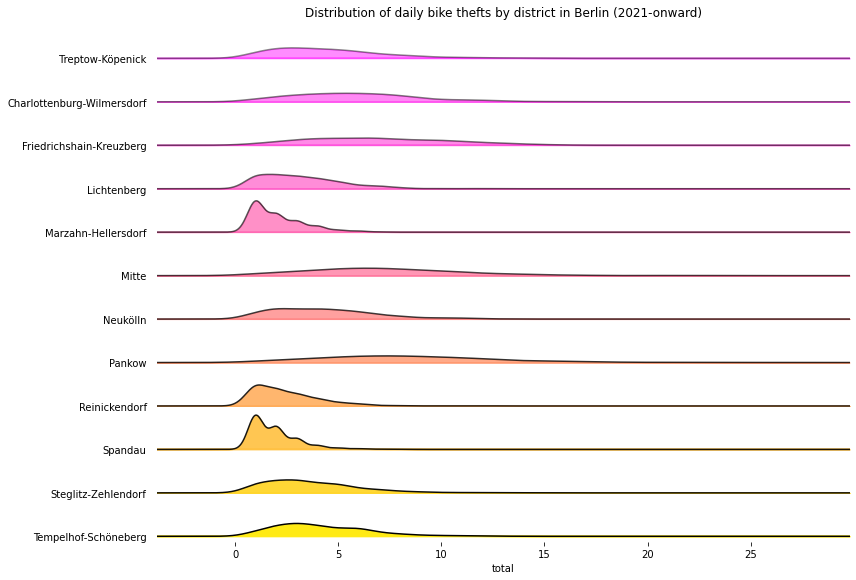

In [541]:
ridge_plot_theft(df)